In [8]:
import torch
from torch import nn

오늘날 딥러닝은 엄청난 데이터와의 싸움이다


Multi-GPU  
어떻게 GPU를 다룰 것인가

### 개념
- Single vs Multi
- GPU vs Node(1대의 컴퓨터) 
- Single Nodel Single GPU(1대의 컴퓨터 1개의 GPU)
- Single Node Multi GPU(1대의 컴퓨터 여러개의 GPU)
- Multi Node Multi GPU(여려대의 컴퓨터 여러개의 GPU)

엔비디아의 TensorRT 는 GPU를 잘 사용할 수 있게 도와준다.

### Model parallel(모델 병렬화)
- 다중 GPU에 학습을 분산하는 두가지 방법  
    모델 나누기 / 데이터 나누기
- 모델을 나누는 것은 생각보다 예전부터 사용했다(alexnet)
- 모델의 병목, 파이프라인의 어려움등으로 인해 모델 병렬화는 고난이도 과제

alex net

<img src = "../images/ai_34.png">

__모델 병렬화의 문제__
- 파이프라인에 빈공간이 생김(위 사진)
- 같이 진행되어야 올바른 병렬화(아래 사진)

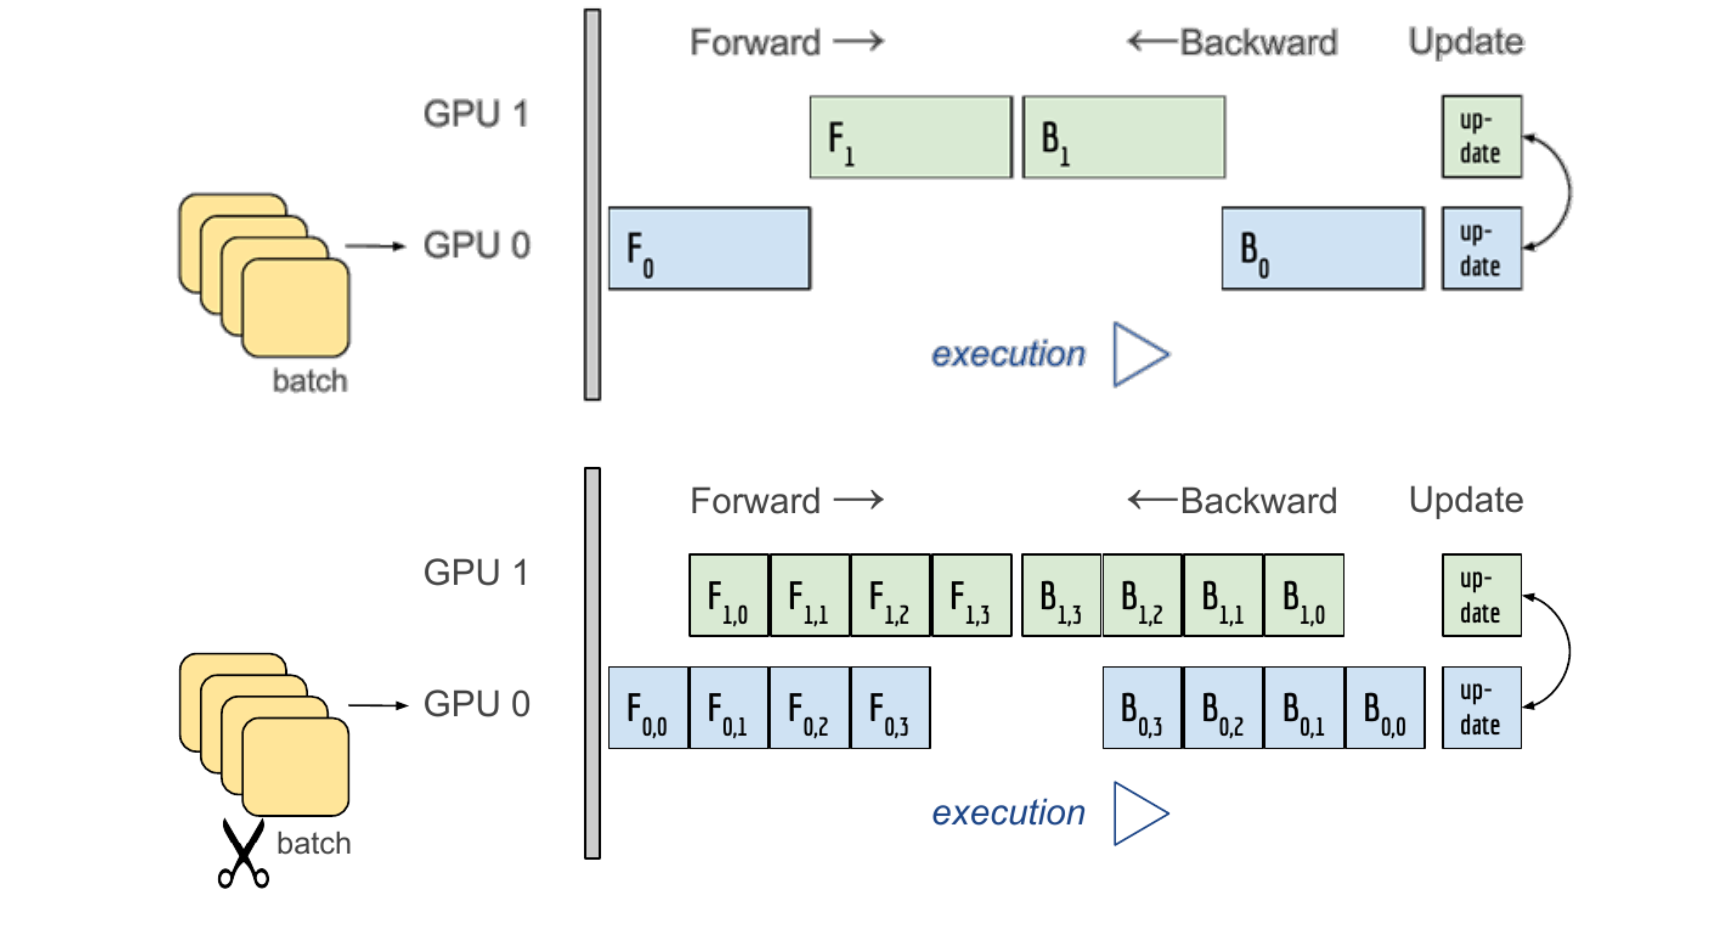

In [9]:
class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes = num_classes, *args, **kwargs)
        
        # 첫번째 모델을 cuda 0에 할당
        self.seq1 = nn.Sequential(
            self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2
        ).to('cuda:0')
        
        # 두번째 모델을 cuda 1에 할당
        self.seq2 = nn.Sequential(
            self.layer3, self.layer4, self.avgpool,
        ).to('cuda:1')
        
        self.fc.to('cuda:1')
    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

NameError: name 'ResNet' is not defined

### Data parallel
- 데이터를 나눠 GPU에 할당 후 결과의 평균을 취하는 방법
- minibatch 수식과 유사한데 한번에 여러 GPU에서 수행
- minibatch를 병렬적으로 돌리는 것으로 이해 할 수도 있다.
- PyTorch에서는 두가지 방식을 제공한다.  
    __DataParallel, DistributedDataParallel__  
- DataParallel : 단순히 데이터를 분배한 후 평균을 취함  
    $\rightarrow$ GPU사용 불균형 문제 발생, Batch사이즈 감소(한 GPU가 병목), GIL  
- DistributedDataParallel : 각 CPU마다 process를 생성하여 개별 GPU에 할당  
    $\rightarrow$ 기본적으로 DataParallel로 하나 개별적으로 연산의 평균을 냄

In [5]:
# 코드는 이 한줄로 간단하다
parallel_model = torch.nn.Dataparallel(model)

NameError: name 'torch' is not defined

### DistributedDataParallel
- 코드가 몇가지 작업을 거쳐야한다.
- Sampler 사용
- map reduce 개념(Python의 멀티프로세싱 코드)
- 멀티프로세싱 통신 규약정의
- Distributed DataParallel 정의

In [11]:
# Sampler를 사용
train_sampler = torch.utils.data.distrubuted.DistributedSampler(train_data)
shuffle = False
pin_memory = True

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 20, shuffle = True
                                        pin_memory = pin_memory, num_workers = 3,
                                         shuffle = shuffle, sampler = train_sampler)

SyntaxError: invalid syntax (1596097496.py, line 7)